## Convolutional DNN

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from attack_utils import get_synonymes#, attack, predict_sentence
import random
import nltk
import operator
from tqdm import tqdm
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,LSTM,Embedding,Flatten,Dense
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation,TimeDistributed
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization,MaxPooling1D, Convolution1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras import backend as K
from keras import layers
from keras.models import Sequential, Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rusha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rusha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2
SAVE_MODEL_PATH = './save/model/'
TEXT_DATA = 'data/fake_or_real_news.csv'
EMBEDDING_FILE=f'glove.6B.{EMBEDDING_DIM}d.txt'

In [3]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [4]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


In [5]:
# vectorize the text samples into a 2D integer tensor 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 99682 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [6]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT)

In [7]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

In [8]:

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [9]:
BATCH_SIZE = 128

# convs = []
# filter_sizes = [3,4,5]
model=None
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NUM_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


embedded_sequences = embedding_layer(sequence_input)
# l_lstm = Bidirectional(LSTM(100, return_sequences=True))(embedded_sequences)
l_lstm = LSTM(100, return_sequences=True)(embedded_sequences)
f = Flatten()(l_lstm)
# preds = Dense(1, activation='softmax')(f)
preds = Dense(1, activation='sigmoid')(f)
# preds = TimeDistributed(2, Dense(200,activation='relu'))(l_gru)
model = Model(sequence_input, preds)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - LSTM network")
# checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
model fitting - LSTM network
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 300)         7500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 5000, 100)         160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 500001    
Total params: 8,160,401
Trainable params: 660,401
Non-trainable params: 7,500,000
____________________________________________________

In [10]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [11]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_ourfakes(model, Fake_texts):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    missclasified_fakes = []
    correct_clasified_fakes = []
    def predict(X):
        return np.rint(model.predict(X))
    # training error
    y_predict = predict(Fake_texts)
    y = np.zeros(len(y_predict))
    for i in range(len(y_predict)):
        missclasified_fakes.append(Fake_texts[i]) if y_predict[i] == 1 else correct_clasified_fakes.append(Fake_texts[i])
    acc = accuracy_score(y,y_predict) #model.evaluate(Fake_texts,y)
    return acc, missclasified_fakes, correct_clasified_fakes

In [12]:
model.load_weights(SAVE_MODEL_PATH+'glove_LSTM_model.h5') # replace X with the last saved checkpoint number


In [13]:
def predict_sentence(model,sent):
    try_vector = tokenizer.texts_to_sequences([sent])
    try_vector = pad_sequences([try_vector[0]], 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')
    val = model.predict(try_vector)
    return val


In [14]:
faker = list(df['label'].apply(lambda x: x == 'FAKE'))
fakes = df[faker]
fake_texts = fakes['text']
# fake_labels = fakes['label']

In [15]:
fake_text_vectors = tokenizer.texts_to_sequences(fake_texts)
fake_text_vectors = pad_sequences(fake_text_vectors, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

In [16]:
acc, missclasified_fakes, correct_clasified_fakes = evaluate_ourfakes(model, fake_text_vectors)

In [17]:
print("total missclassified fakes",len(missclasified_fakes),"total correctly classified fakes",len(correct_clasified_fakes))

total missclassified fakes 827 total correctly classified fakes 2337


In [18]:
correct_fakes =tokenizer.sequences_to_texts(correct_clasified_fakes)

In [19]:
# with open(f'CNN1d_correct_fakes.txt','w', encoding="utf-8") as f:
#     f.writelines(correct_fakes)

In [20]:
# with open(f'CNN1d_correct_fakes.txt','r', encoding="utf-8") as f:
#     correct_fakes = f.readlines()

In [171]:
def attack(dummy,pertub=1, printSwaps = False):    
    dummy_temp = nltk.word_tokenize(dummy[:MAX_SEQUENCE_LENGTH])
    second_dummy = nltk.word_tokenize(dummy[:MAX_SEQUENCE_LENGTH])
    success_index=[]
    done = False
    unsuccessfullSwaps = 0
    for i in range(int(len(dummy_temp)*pertub)):
        if done:
            break
        itter = 0
        while itter<10000:
            itter+=1
            v = random.randint(0,len(dummy_temp)-1)
            syns,_ = get_synonymes(dummy_temp[v])
            if len(syns)>0:
                break
        if itter == 10000:
            print("didnt catch any synonymes")
            continue
        candidates = {}
        # candidate is a scored candidate dictionary storing all the 
        # synonymes with prediction Score
        word = dummy_temp[v]
        sent = " ".join(dummy_temp)
        candidates[word]=predict_sentence(model,sent)
        for s in syns:
            dummy_temp[v] = s
            sent = (" ".join(dummy_temp))
            val = predict_sentence(model,sent)
            candidates[s] = val
            if val>=0.5:
#                 print("got changes in ",i,val)
                success_index.append(v)
                done = True
                break
    #         best_candidate = max(candidates.iteritems(), key=operator.itemgetter(1))[0]
        best_candidate = max(candidates, key=candidates.get)
        if word == best_candidate:
            unsuccessfullSwaps+=1
        else:
            success_index.append(v)
#             if printSwaps:
#                 print("did not swap")
#         else:
#             if printSwaps:
#             print(word,best_candidate)
        dummy_temp[v] = best_candidate
    if not done:
#         print("sorry")
        return 0,None
    for i in set(success_index):
        dummy_temp[i] = "\emph{\{"+dummy_temp[i]+"/"+second_dummy[i]+"\}}"
    print("swaps done ",i-unsuccessfullSwaps,"total words",len(dummy_temp),"unsucessfull swaps try",unsuccessfullSwaps)
    return i-unsuccessfullSwaps," ".join(dummy_temp)

In [27]:
success_on = np.zeros(len(correct_fakes),dtype='int16')
# for i in tqdm(range(len(correct_fakes))):
# for i in tqdm(range(300)):
for i in tqdm(range(200)):
    success_on[i],_ = attack(correct_fakes[i],1)



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [02:29<8:14:32, 149.11s/it]

swaps done  27 total words 926 unsucessfull swaps try 4




  1%|          | 2/200 [10:33<13:43:29, 249.54s/it]

swaps done  57 total words 455 unsucessfull swaps try 31




  2%|▏         | 3/200 [10:34<9:34:40, 175.03s/it] 

swaps done  2 total words 427 unsucessfull swaps try 0




  2%|▏         | 4/200 [12:46<8:50:10, 162.30s/it]

swaps done  24 total words 947 unsucessfull swaps try 7




  2%|▎         | 5/200 [22:42<15:49:46, 292.24s/it]

swaps done  76 total words 563 unsucessfull swaps try 36




  3%|▎         | 6/200 [33:37<21:36:49, 401.08s/it]

swaps done  93 total words 222 unsucessfull swaps try 54




  4%|▎         | 7/200 [33:44<15:09:55, 282.88s/it]

swaps done  4 total words 55 unsucessfull swaps try 0




  4%|▍         | 8/200 [38:00<14:39:32, 274.86s/it]

swaps done  43 total words 145 unsucessfull swaps try 13




  4%|▍         | 9/200 [51:29<23:05:31, 435.24s/it]

swaps done  99 total words 287 unsucessfull swaps try 62




  5%|▌         | 10/200 [57:47<22:03:25, 417.92s/it]

swaps done  61 total words 196 unsucessfull swaps try 26




  6%|▌         | 11/200 [58:31<16:03:22, 305.83s/it]

swaps done  12 total words 813 unsucessfull swaps try 3




  6%|▌         | 12/200 [1:04:17<16:35:37, 317.75s/it]

swaps done  59 total words 713 unsucessfull swaps try 21




  6%|▋         | 13/200 [1:20:46<26:58:22, 519.26s/it]

swaps done  137 total words 514 unsucessfull swaps try 67




  7%|▋         | 14/200 [1:36:13<33:08:48, 641.55s/it]

swaps done  111 total words 753 unsucessfull swaps try 55




  8%|▊         | 15/200 [1:40:41<27:12:31, 529.47s/it]

swaps done  40 total words 315 unsucessfull swaps try 16




  8%|▊         | 16/200 [1:51:40<29:02:43, 568.28s/it]

swaps done  95 total words 1008 unsucessfull swaps try 39




  8%|▊         | 17/200 [1:55:12<23:27:34, 461.50s/it]

swaps done  30 total words 362 unsucessfull swaps try 15




  9%|▉         | 18/200 [1:58:08<18:59:59, 375.82s/it]

swaps done  27 total words 344 unsucessfull swaps try 9




 10%|▉         | 19/200 [2:04:52<19:19:23, 384.33s/it]

swaps done  64 total words 258 unsucessfull swaps try 39




 10%|█         | 20/200 [2:07:13<15:33:36, 311.20s/it]

swaps done  24 total words 241 unsucessfull swaps try 13




 10%|█         | 21/200 [2:11:04<14:16:49, 287.20s/it]

swaps done  38 total words 515 unsucessfull swaps try 14




 11%|█         | 22/200 [2:12:51<11:31:58, 233.25s/it]

swaps done  20 total words 58 unsucessfull swaps try 3




 12%|█▏        | 23/200 [2:23:13<17:11:45, 349.75s/it]

swaps done  82 total words 303 unsucessfull swaps try 39




 12%|█▏        | 24/200 [2:30:51<18:40:47, 382.09s/it]

swaps done  74 total words 525 unsucessfull swaps try 30




 12%|█▎        | 25/200 [2:36:32<17:58:53, 369.91s/it]

swaps done  49 total words 190 unsucessfull swaps try 20




 13%|█▎        | 26/200 [2:46:27<21:08:40, 437.47s/it]

swaps done  72 total words 198 unsucessfull swaps try 36




 14%|█▎        | 27/200 [2:47:49<15:53:31, 330.70s/it]

swaps done  15 total words 31 unsucessfull swaps try 5




 14%|█▍        | 28/200 [2:49:00<12:04:28, 252.72s/it]

swaps done  12 total words 34 unsucessfull swaps try 7




 14%|█▍        | 29/200 [3:04:12<21:23:58, 450.52s/it]

swaps done  124 total words 368 unsucessfull swaps try 34




 15%|█▌        | 30/200 [3:07:50<17:59:34, 381.03s/it]

swaps done  42 total words 847 unsucessfull swaps try 12




 16%|█▌        | 31/200 [3:08:31<13:05:22, 278.83s/it]

swaps done  10 total words 32 unsucessfull swaps try 2




 16%|█▌        | 32/200 [3:18:12<17:14:53, 369.61s/it]

swaps done  70 total words 199 unsucessfull swaps try 52




 16%|█▋        | 33/200 [3:26:09<18:38:18, 401.79s/it]

swaps done  77 total words 455 unsucessfull swaps try 26




 17%|█▋        | 34/200 [3:33:18<18:53:40, 409.76s/it]

swaps done  73 total words 353 unsucessfull swaps try 15




 18%|█▊        | 35/200 [3:38:12<17:12:03, 375.29s/it]

swaps done  56 total words 429 unsucessfull swaps try 8




 18%|█▊        | 36/200 [3:47:57<19:57:49, 438.23s/it]

swaps done  66 total words 205 unsucessfull swaps try 29




 18%|█▊        | 37/200 [3:48:51<14:36:46, 322.74s/it]

swaps done  9 total words 140 unsucessfull swaps try 6




 19%|█▉        | 38/200 [3:59:38<18:54:38, 420.24s/it]

swaps done  86 total words 219 unsucessfull swaps try 55




 20%|█▉        | 39/200 [4:09:24<21:00:34, 469.78s/it]

swaps done  72 total words 958 unsucessfull swaps try 43




 20%|██        | 40/200 [4:18:44<22:05:19, 497.00s/it]

swaps done  90 total words 298 unsucessfull swaps try 36




 20%|██        | 41/200 [4:23:20<19:01:21, 430.70s/it]

swaps done  32 total words 375 unsucessfull swaps try 20




 21%|██        | 42/200 [4:40:24<26:42:21, 608.49s/it]

swaps done  132 total words 507 unsucessfull swaps try 61




 22%|██▏       | 43/200 [4:40:25<18:35:25, 426.28s/it]

swaps done  2 total words 816 unsucessfull swaps try 0




 22%|██▏       | 44/200 [4:40:27<12:57:10, 298.91s/it]

swaps done  2 total words 29 unsucessfull swaps try 0




 23%|██▎       | 46/200 [4:52:01<13:24:20, 313.38s/it]

swaps done  106 total words 500 unsucessfull swaps try 44




 24%|██▎       | 47/200 [4:56:14<12:33:06, 295.34s/it]

swaps done  39 total words 560 unsucessfull swaps try 12




 24%|██▍       | 48/200 [5:02:03<13:09:08, 311.50s/it]

swaps done  47 total words 337 unsucessfull swaps try 19




 24%|██▍       | 49/200 [5:06:27<12:27:37, 297.07s/it]

swaps done  45 total words 494 unsucessfull swaps try 18




 25%|██▌       | 50/200 [5:09:51<11:13:10, 269.27s/it]

swaps done  32 total words 149 unsucessfull swaps try 15




 26%|██▌       | 51/200 [5:20:56<16:03:38, 388.04s/it]

swaps done  89 total words 534 unsucessfull swaps try 50




 26%|██▌       | 52/200 [5:22:06<12:01:20, 292.44s/it]

swaps done  15 total words 836 unsucessfull swaps try 10




 26%|██▋       | 53/200 [5:30:25<14:28:16, 354.40s/it]

swaps done  74 total words 275 unsucessfull swaps try 39




 27%|██▋       | 54/200 [5:35:52<14:02:53, 346.39s/it]

swaps done  50 total words 373 unsucessfull swaps try 25




 28%|██▊       | 55/200 [5:42:07<14:17:23, 354.78s/it]

swaps done  58 total words 244 unsucessfull swaps try 25




 28%|██▊       | 56/200 [5:42:08<9:56:49, 248.68s/it] 

swaps done  1 total words 511 unsucessfull swaps try 1




 28%|██▊       | 57/200 [5:50:42<13:02:44, 328.42s/it]

swaps done  64 total words 546 unsucessfull swaps try 29




 29%|██▉       | 58/200 [5:52:22<10:14:48, 259.78s/it]

swaps done  19 total words 88 unsucessfull swaps try 10




 30%|██▉       | 59/200 [5:58:48<11:39:14, 297.55s/it]

swaps done  53 total words 219 unsucessfull swaps try 30




 30%|███       | 60/200 [5:58:49<8:06:46, 208.62s/it] 

swaps done  2 total words 933 unsucessfull swaps try 0




 30%|███       | 61/200 [5:59:46<6:18:07, 163.22s/it]

swaps done  14 total words 918 unsucessfull swaps try 2




 31%|███       | 62/200 [6:06:00<8:41:00, 226.52s/it]

swaps done  53 total words 587 unsucessfull swaps try 25




 32%|███▏      | 63/200 [6:10:34<9:09:42, 240.75s/it]

swaps done  40 total words 284 unsucessfull swaps try 14




 32%|███▏      | 64/200 [6:14:17<8:53:45, 235.48s/it]

swaps done  31 total words 696 unsucessfull swaps try 8




 32%|███▎      | 65/200 [6:14:22<6:13:49, 166.15s/it]

swaps done  3 total words 18 unsucessfull swaps try 0




 33%|███▎      | 66/200 [6:27:35<13:11:12, 354.28s/it]

swaps done  122 total words 909 unsucessfull swaps try 32




 34%|███▎      | 67/200 [6:31:24<11:42:01, 316.70s/it]

swaps done  29 total words 240 unsucessfull swaps try 12




 34%|███▍      | 68/200 [6:31:25<8:08:27, 222.03s/it] 

swaps done  2 total words 792 unsucessfull swaps try 0




 34%|███▍      | 69/200 [6:31:41<5:50:04, 160.34s/it]

swaps done  4 total words 968 unsucessfull swaps try 0




 35%|███▌      | 70/200 [6:33:06<4:58:04, 137.58s/it]

swaps done  16 total words 192 unsucessfull swaps try 12




 36%|███▌      | 71/200 [6:38:17<6:47:57, 189.75s/it]

swaps done  38 total words 266 unsucessfull swaps try 16




 36%|███▌      | 72/200 [6:43:22<7:58:33, 224.33s/it]

swaps done  47 total words 936 unsucessfull swaps try 12




 36%|███▋      | 73/200 [6:47:04<7:52:53, 223.42s/it]

swaps done  36 total words 112 unsucessfull swaps try 11




 37%|███▋      | 74/200 [6:54:37<10:13:56, 292.35s/it]

swaps done  59 total words 251 unsucessfull swaps try 30




 38%|███▊      | 75/200 [6:59:38<10:14:36, 295.01s/it]

swaps done  35 total words 880 unsucessfull swaps try 14




 38%|███▊      | 76/200 [7:02:25<8:50:20, 256.62s/it] 

swaps done  28 total words 62 unsucessfull swaps try 9




 38%|███▊      | 77/200 [7:03:19<6:41:24, 195.81s/it]

swaps done  13 total words 634 unsucessfull swaps try 1




 39%|███▉      | 78/200 [7:16:12<12:29:58, 368.84s/it]

swaps done  103 total words 752 unsucessfull swaps try 34




 40%|███▉      | 79/200 [7:28:21<16:01:38, 476.84s/it]

swaps done  106 total words 880 unsucessfull swaps try 67




 40%|████      | 80/200 [7:34:33<14:50:57, 445.48s/it]

swaps done  51 total words 353 unsucessfull swaps try 19




 40%|████      | 81/200 [7:37:13<11:53:43, 359.86s/it]

swaps done  24 total words 73 unsucessfull swaps try 9




 41%|████      | 82/200 [7:43:41<12:04:33, 368.42s/it]

swaps done  52 total words 196 unsucessfull swaps try 18




 42%|████▏     | 83/200 [7:53:59<14:24:21, 443.26s/it]

swaps done  80 total words 574 unsucessfull swaps try 20




 42%|████▏     | 84/200 [8:02:26<14:53:39, 462.24s/it]

swaps done  78 total words 665 unsucessfull swaps try 41




 42%|████▎     | 85/200 [8:07:58<13:31:15, 423.27s/it]

swaps done  48 total words 921 unsucessfull swaps try 20




 43%|████▎     | 86/200 [8:18:18<15:16:29, 482.36s/it]

swaps done  83 total words 486 unsucessfull swaps try 33




 44%|████▎     | 87/200 [8:28:19<16:15:20, 517.88s/it]

swaps done  81 total words 384 unsucessfull swaps try 40




 44%|████▍     | 88/200 [8:38:39<17:03:43, 548.42s/it]

swaps done  86 total words 434 unsucessfull swaps try 43




 44%|████▍     | 89/200 [8:49:01<17:35:43, 570.66s/it]

swaps done  62 total words 248 unsucessfull swaps try 45




 45%|████▌     | 90/200 [9:03:45<20:18:15, 664.50s/it]

swaps done  116 total words 362 unsucessfull swaps try 48




 46%|████▌     | 91/200 [9:06:07<15:22:42, 507.91s/it]

swaps done  25 total words 125 unsucessfull swaps try 5




 46%|████▌     | 92/200 [9:11:27<13:32:39, 451.48s/it]

swaps done  44 total words 253 unsucessfull swaps try 14




 46%|████▋     | 93/200 [9:22:07<15:05:50, 507.95s/it]

swaps done  100 total words 848 unsucessfull swaps try 38




 47%|████▋     | 94/200 [9:23:15<11:04:27, 376.11s/it]

swaps done  14 total words 26 unsucessfull swaps try 2




 48%|████▊     | 95/200 [9:35:46<14:14:56, 488.54s/it]

swaps done  110 total words 904 unsucessfull swaps try 43




 48%|████▊     | 96/200 [9:41:28<12:50:19, 444.42s/it]

swaps done  37 total words 80 unsucessfull swaps try 31




 48%|████▊     | 97/200 [9:51:27<14:02:45, 490.93s/it]

swaps done  95 total words 499 unsucessfull swaps try 43




 49%|████▉     | 98/200 [9:57:45<12:57:04, 457.11s/it]

swaps done  60 total words 529 unsucessfull swaps try 25




 50%|████▉     | 99/200 [9:58:28<9:20:16, 332.83s/it] 

swaps done  9 total words 922 unsucessfull swaps try 2




 50%|█████     | 100/200 [10:04:59<9:43:51, 350.31s/it]

swaps done  54 total words 650 unsucessfull swaps try 18




 50%|█████     | 101/200 [10:06:34<7:31:45, 273.79s/it]

swaps done  15 total words 757 unsucessfull swaps try 6




 51%|█████     | 102/200 [10:09:49<6:48:26, 250.07s/it]

swaps done  32 total words 213 unsucessfull swaps try 8




 52%|█████▏    | 103/200 [10:13:53<6:41:09, 248.14s/it]

swaps done  30 total words 45 unsucessfull swaps try 9




 52%|█████▏    | 104/200 [10:13:54<4:38:27, 174.03s/it]

swaps done  1 total words 831 unsucessfull swaps try 1




 52%|█████▎    | 105/200 [10:13:55<3:13:24, 122.16s/it]

swaps done  1 total words 822 unsucessfull swaps try 1




 53%|█████▎    | 106/200 [10:23:49<6:52:56, 263.58s/it]

swaps done  79 total words 437 unsucessfull swaps try 25




 54%|█████▎    | 107/200 [10:23:57<4:50:05, 187.16s/it]

swaps done  3 total words 128 unsucessfull swaps try 0




 54%|█████▍    | 108/200 [10:29:39<5:58:12, 233.61s/it]

swaps done  49 total words 339 unsucessfull swaps try 24




 55%|█████▍    | 109/200 [10:56:54<16:31:41, 653.87s/it]

swaps done  196 total words 767 unsucessfull swaps try 109




 55%|█████▌    | 110/200 [11:04:54<15:02:44, 601.83s/it]

swaps done  59 total words 307 unsucessfull swaps try 33




 56%|█████▌    | 111/200 [11:08:04<11:49:20, 478.21s/it]

swaps done  39 total words 264 unsucessfull swaps try 9




 56%|█████▌    | 112/200 [11:18:41<12:51:12, 525.83s/it]

swaps done  81 total words 911 unsucessfull swaps try 50




 56%|█████▋    | 113/200 [11:19:00<9:02:00, 373.80s/it] 

swaps done  5 total words 10 unsucessfull swaps try 0




 57%|█████▋    | 114/200 [11:19:03<6:16:28, 262.65s/it]

swaps done  2 total words 867 unsucessfull swaps try 0




 57%|█████▊    | 115/200 [11:19:52<4:41:15, 198.54s/it]

swaps done  10 total words 32 unsucessfull swaps try 2




 58%|█████▊    | 116/200 [11:24:11<5:03:11, 216.57s/it]

swaps done  40 total words 619 unsucessfull swaps try 15




 58%|█████▊    | 117/200 [11:26:42<4:32:31, 197.01s/it]

swaps done  30 total words 885 unsucessfull swaps try 5




 59%|█████▉    | 118/200 [11:28:04<3:42:04, 162.50s/it]

swaps done  18 total words 875 unsucessfull swaps try 2




 60%|█████▉    | 119/200 [11:42:22<8:21:03, 371.16s/it]

swaps done  126 total words 888 unsucessfull swaps try 53




 60%|██████    | 120/200 [11:47:04<7:39:14, 344.43s/it]

swaps done  43 total words 957 unsucessfull swaps try 15




 60%|██████    | 121/200 [11:48:04<5:41:00, 258.99s/it]

swaps done  12 total words 884 unsucessfull swaps try 3




 61%|██████    | 122/200 [11:52:19<5:35:00, 257.69s/it]

swaps done  42 total words 441 unsucessfull swaps try 22




 62%|██████▏   | 123/200 [12:00:48<7:07:29, 333.10s/it]

swaps done  72 total words 304 unsucessfull swaps try 47




 62%|██████▏   | 124/200 [12:01:59<5:22:16, 254.42s/it]

swaps done  11 total words 50 unsucessfull swaps try 6




 62%|██████▎   | 125/200 [12:06:55<5:33:41, 266.96s/it]

swaps done  45 total words 449 unsucessfull swaps try 21




 63%|██████▎   | 126/200 [12:14:37<6:41:29, 325.54s/it]

swaps done  51 total words 230 unsucessfull swaps try 36




 64%|██████▎   | 127/200 [12:23:53<7:59:59, 394.52s/it]

swaps done  76 total words 234 unsucessfull swaps try 50




 64%|██████▍   | 128/200 [12:23:54<5:31:47, 276.50s/it]

swaps done  2 total words 923 unsucessfull swaps try 0




 64%|██████▍   | 129/200 [12:32:21<6:49:11, 345.79s/it]

swaps done  75 total words 382 unsucessfull swaps try 35




 65%|██████▌   | 130/200 [12:33:37<5:08:51, 264.73s/it]

swaps done  14 total words 32 unsucessfull swaps try 8




 66%|██████▌   | 131/200 [12:34:10<3:44:38, 195.34s/it]

swaps done  7 total words 889 unsucessfull swaps try 2




 66%|██████▌   | 132/200 [12:40:10<4:37:11, 244.58s/it]

swaps done  54 total words 698 unsucessfull swaps try 13




 66%|██████▋   | 133/200 [12:40:11<3:11:33, 171.55s/it]

swaps done  1 total words 951 unsucessfull swaps try 1




 67%|██████▋   | 134/200 [12:47:02<4:27:56, 243.59s/it]

swaps done  47 total words 173 unsucessfull swaps try 50




 68%|██████▊   | 135/200 [12:50:15<4:07:14, 228.23s/it]

swaps done  36 total words 336 unsucessfull swaps try 14




 68%|██████▊   | 136/200 [12:50:53<3:02:29, 171.08s/it]

swaps done  7 total words 843 unsucessfull swaps try 1




 68%|██████▊   | 137/200 [12:50:58<2:07:28, 121.40s/it]

swaps done  3 total words 876 unsucessfull swaps try 0




 69%|██████▉   | 138/200 [12:56:00<3:01:31, 175.67s/it]

swaps done  43 total words 649 unsucessfull swaps try 10




 70%|██████▉   | 139/200 [13:05:28<4:58:01, 293.13s/it]

swaps done  69 total words 214 unsucessfull swaps try 44




 70%|███████   | 140/200 [13:11:15<5:09:26, 309.44s/it]

swaps done  53 total words 877 unsucessfull swaps try 12




 70%|███████   | 141/200 [13:15:24<4:46:20, 291.19s/it]

swaps done  31 total words 84 unsucessfull swaps try 23




 71%|███████   | 142/200 [13:27:14<6:42:59, 416.88s/it]

swaps done  106 total words 916 unsucessfull swaps try 51




 72%|███████▏  | 143/200 [13:33:11<6:19:04, 399.03s/it]

swaps done  46 total words 484 unsucessfull swaps try 30




 72%|███████▏  | 144/200 [13:41:35<6:41:44, 430.45s/it]

swaps done  71 total words 861 unsucessfull swaps try 20




 72%|███████▎  | 145/200 [13:46:17<5:53:50, 386.01s/it]

swaps done  34 total words 294 unsucessfull swaps try 22




 73%|███████▎  | 146/200 [13:53:02<5:52:22, 391.53s/it]

swaps done  61 total words 993 unsucessfull swaps try 27




 74%|███████▎  | 147/200 [14:00:11<5:55:54, 402.91s/it]

swaps done  61 total words 333 unsucessfull swaps try 27




 74%|███████▍  | 148/200 [14:03:52<5:01:56, 348.40s/it]

swaps done  32 total words 69 unsucessfull swaps try 11




 74%|███████▍  | 149/200 [14:05:07<3:46:24, 266.36s/it]

swaps done  14 total words 828 unsucessfull swaps try 6




 75%|███████▌  | 150/200 [14:19:36<6:12:36, 447.13s/it]

swaps done  113 total words 450 unsucessfull swaps try 75




 76%|███████▌  | 151/200 [14:25:18<5:39:16, 415.44s/it]

swaps done  45 total words 151 unsucessfull swaps try 34




 76%|███████▌  | 152/200 [14:34:29<6:04:52, 456.09s/it]

swaps done  75 total words 211 unsucessfull swaps try 35




 76%|███████▋  | 153/200 [14:36:21<4:36:36, 353.12s/it]

swaps done  17 total words 57 unsucessfull swaps try 8




 77%|███████▋  | 154/200 [14:39:47<3:56:53, 308.99s/it]

swaps done  20 total words 264 unsucessfull swaps try 7




 78%|███████▊  | 155/200 [14:42:23<3:17:16, 263.04s/it]

swaps done  31 total words 717 unsucessfull swaps try 5




 78%|███████▊  | 156/200 [14:43:58<2:35:56, 212.65s/it]

swaps done  20 total words 389 unsucessfull swaps try 3




 78%|███████▊  | 157/200 [14:44:16<1:50:26, 154.10s/it]

swaps done  7 total words 313 unsucessfull swaps try 0




 79%|███████▉  | 158/200 [14:56:45<3:52:46, 332.53s/it]

swaps done  92 total words 383 unsucessfull swaps try 38




 80%|███████▉  | 159/200 [15:05:53<4:31:29, 397.30s/it]

swaps done  95 total words 335 unsucessfull swaps try 22




 80%|████████  | 160/200 [15:06:12<3:09:08, 283.72s/it]

swaps done  8 total words 35 unsucessfull swaps try 0




 80%|████████  | 161/200 [15:11:03<3:05:46, 285.80s/it]

swaps done  43 total words 345 unsucessfull swaps try 22




 81%|████████  | 162/200 [15:13:56<2:39:42, 252.18s/it]

swaps done  38 total words 65 unsucessfull swaps try 10




 82%|████████▏ | 163/200 [15:19:13<2:47:24, 271.46s/it]

swaps done  52 total words 832 unsucessfull swaps try 20




 82%|████████▏ | 164/200 [15:25:17<2:59:35, 299.32s/it]

swaps done  49 total words 408 unsucessfull swaps try 27




 82%|████████▎ | 165/200 [15:37:02<4:05:34, 420.99s/it]

swaps done  98 total words 607 unsucessfull swaps try 62




 83%|████████▎ | 166/200 [15:50:04<4:59:57, 529.35s/it]

swaps done  86 total words 637 unsucessfull swaps try 47




 84%|████████▎ | 167/200 [15:56:21<4:25:59, 483.64s/it]

swaps done  54 total words 314 unsucessfull swaps try 22




 84%|████████▍ | 168/200 [16:05:33<4:28:56, 504.27s/it]

swaps done  79 total words 858 unsucessfull swaps try 32




 84%|████████▍ | 169/200 [16:19:15<5:09:38, 599.31s/it]

swaps done  112 total words 750 unsucessfull swaps try 42




 85%|████████▌ | 170/200 [16:29:08<4:58:48, 597.60s/it]

swaps done  77 total words 724 unsucessfull swaps try 32




 86%|████████▌ | 171/200 [16:38:49<4:46:25, 592.62s/it]

swaps done  81 total words 922 unsucessfull swaps try 27




 86%|████████▌ | 172/200 [16:48:51<4:37:52, 595.44s/it]

swaps done  68 total words 272 unsucessfull swaps try 34




 86%|████████▋ | 173/200 [16:57:57<4:21:13, 580.49s/it]

swaps done  87 total words 455 unsucessfull swaps try 30




 87%|████████▋ | 174/200 [17:05:24<3:54:10, 540.42s/it]

swaps done  69 total words 375 unsucessfull swaps try 36




 88%|████████▊ | 175/200 [17:11:23<3:22:29, 485.98s/it]

swaps done  45 total words 183 unsucessfull swaps try 21




 88%|████████▊ | 176/200 [17:12:58<2:27:30, 368.77s/it]

swaps done  24 total words 722 unsucessfull swaps try 2




 88%|████████▊ | 177/200 [17:17:50<2:12:30, 345.66s/it]

swaps done  45 total words 902 unsucessfull swaps try 20




 89%|████████▉ | 178/200 [17:26:17<2:24:30, 394.12s/it]

swaps done  77 total words 461 unsucessfull swaps try 30




 90%|████████▉ | 179/200 [17:29:00<1:53:41, 324.84s/it]

swaps done  25 total words 401 unsucessfull swaps try 11




 90%|█████████ | 180/200 [17:30:18<1:23:36, 250.85s/it]

swaps done  13 total words 893 unsucessfull swaps try 2




 90%|█████████ | 181/200 [17:34:36<1:20:06, 252.96s/it]

swaps done  31 total words 957 unsucessfull swaps try 12




 91%|█████████ | 182/200 [17:42:39<1:36:36, 322.02s/it]

swaps done  70 total words 417 unsucessfull swaps try 30




 92%|█████████▏| 183/200 [17:52:02<1:51:40, 394.13s/it]

swaps done  75 total words 859 unsucessfull swaps try 28




 92%|█████████▏| 184/200 [18:06:01<2:20:42, 527.66s/it]

swaps done  123 total words 606 unsucessfull swaps try 67




 92%|█████████▎| 185/200 [18:13:46<2:07:12, 508.86s/it]

swaps done  82 total words 850 unsucessfull swaps try 28




 93%|█████████▎| 186/200 [18:16:06<1:32:53, 398.12s/it]

swaps done  26 total words 172 unsucessfull swaps try 12




 94%|█████████▎| 187/200 [18:19:36<1:14:04, 341.87s/it]

swaps done  41 total words 511 unsucessfull swaps try 4




 94%|█████████▍| 188/200 [18:20:48<52:08, 260.73s/it]  

swaps done  12 total words 33 unsucessfull swaps try 7




 94%|█████████▍| 189/200 [18:34:17<1:17:58, 425.28s/it]

swaps done  109 total words 312 unsucessfull swaps try 54




 95%|█████████▌| 190/200 [18:37:46<1:00:05, 360.57s/it]

swaps done  35 total words 351 unsucessfull swaps try 7




 96%|█████████▌| 191/200 [18:40:57<46:25, 309.50s/it]  

swaps done  32 total words 487 unsucessfull swaps try 11




 96%|█████████▌| 192/200 [18:41:08<29:19, 219.93s/it]

swaps done  4 total words 837 unsucessfull swaps try 1




 96%|█████████▋| 193/200 [18:45:54<27:59, 239.90s/it]

swaps done  45 total words 868 unsucessfull swaps try 25




 97%|█████████▋| 194/200 [18:48:53<22:09, 221.51s/it]

swaps done  25 total words 677 unsucessfull swaps try 18




 98%|█████████▊| 195/200 [18:49:55<14:28, 173.75s/it]

swaps done  17 total words 895 unsucessfull swaps try 3




 98%|█████████▊| 196/200 [19:00:44<21:05, 316.43s/it]

swaps done  97 total words 598 unsucessfull swaps try 47




 98%|█████████▊| 197/200 [19:02:12<12:23, 247.83s/it]

swaps done  17 total words 432 unsucessfull swaps try 7




 99%|█████████▉| 198/200 [19:08:18<09:26, 283.22s/it]

swaps done  59 total words 895 unsucessfull swaps try 21




100%|█████████▉| 199/200 [19:19:14<06:34, 394.95s/it]

swaps done  100 total words 376 unsucessfull swaps try 46




100%|██████████| 200/200 [19:27:35<00:00, 350.28s/it]

swaps done  66 total words 867 unsucessfull swaps try 24


In [28]:
success_on.dump(SAVE_MODEL_PATH+'glove_LSTM_success_rate.npy')

In [29]:
sum(success_on[:200]>0)

199

In [30]:
attack(correct_fakes[0],1)

swaps done  17 total words 926 unsucessfull swaps try 9


(17,
 'daniel greenfield a journalism fellow at the freedom center is a new york writer focusing on radical islam in the final stretch of the election hillary rodham clinton has gone to war with the fbi the word “ unprecedented ” has been thrown around so often this election that it ought to constitute retired but it ’ s still unprecedented for the nominee of a major political party to go war with the fbi but that ’ s exactly what hillary and her people have done patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillary ’ s opponent in this election the fbi is under attack by everyone from obama to cnn hillary ’ s people have circulated a letter attacking comey there are currently more media hit pieces lambasting him than targeting trump it wouldn ’ t be too surprising if the clintons or their allies embody to start running attack ads against the fbi the fbi ’ mho leadership is being warned that the entire lef

In [48]:
success_log = np.zeros((len(correct_fakes),3))

In [49]:
success_log.shape

(3044, 3)

In [71]:
import nltk
for i in range(len(correct_fakes)):
    success_log[i][0] = len(nltk.word_tokenize(correct_fakes[i][:MAX_SEQUENCE_LENGTH]))

In [69]:
success_log.T[1] = success_on

In [72]:
success_log.T[0] 

array([926., 455., 427., ..., 438., 867., 862.])

In [85]:
success_log.T[2] = success_log.T[1]/success_log.T[0]*100

/media/rushabh/B4A46314A462D87E/aml/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [130]:
success_log.dump(SAVE_MODEL_PATH+'glove_LSTM_success_rate.npy')

In [152]:
x= success_on.T[2][:200]

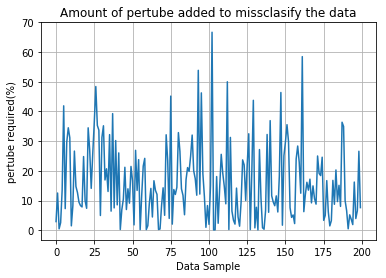

In [153]:
# fig, = plt.plot(x)

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Data Sample', ylabel='pertube required(%)',
       title='Amount of pertube added to missclasify the data')
ax.grid()

fig.savefig("LSTM_pertube_1__0.png")
plt.show()

In [140]:
print("avg amount of pertub required: (in percent)",x.mean())
print("Std  required: ",x.std())
print("minimum pertube  required: (in percent)",x.min())
print("maximum pertube  required: (in percent)",x.max())

avg amount of pertub required: (in percent) 16.459029324643446
Std  required:  14.188366057947972
minimum pertube  required: (in percent) 0.10515247108307045
maximum pertube  required: (in percent) 100.0


In [161]:
print("Allowing pertub < 10 % for missclassification",sum(x<10)/2,"% of the data")
print("Allowing pertub < 15 % for missclassification",sum(x<15)/2,"% of the data")
print("Allowing pertub < 20 % for missclassification",sum(x<20)/2,"% of the data")
print("Allowing pertub < 25 % for missclassification",sum(x<25)/2,"% of the data")
print("Allowing pertub < 35 % for missclassification",sum(x<35)/2,"% of the data")
print("Allowing pertub < 50 % for missclassification",sum(x<50)/2,"% of the data")


Allowing pertub < 10 % for missclassification 41.0 % of the data
Allowing pertub < 15 % for missclassification 58.0 % of the data
Allowing pertub < 20 % for missclassification 68.0 % of the data
Allowing pertub < 25 % for missclassification 76.5 % of the data
Allowing pertub < 35 % for missclassification 91.5 % of the data
Allowing pertub < 50 % for missclassification 98.0 % of the data


In [155]:
y = np.zeros(101,dtype='int')
for i in x:
    y[int(i)]+=1

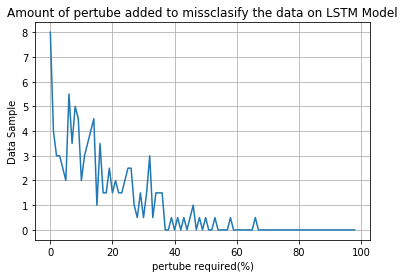

In [160]:
# fig, = plt.plot(x)

fig, ax = plt.subplots()
ax.plot(y[:99]/2)

ax.set(xlabel='pertube required(%)', ylabel='Data Sample',
       title='Amount of pertube added to missclasify the data on LSTM Model')
ax.grid()
txt = "LSTM Model"
# ax.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
fig.savefig("LSTM_pertube_2__0.png")

plt.show()

In [24]:
success_on=np.load(SAVE_MODEL_PATH+'glove_LSTM_success_rate.npy')

In [25]:
success_on

array([[9.26000000e+02, 2.70000000e+01, 2.91576674e+00],
       [4.55000000e+02, 5.70000000e+01, 1.25274725e+01],
       [4.27000000e+02, 2.00000000e+00, 4.68384075e-01],
       ...,
       [4.38000000e+02, 0.00000000e+00, 0.00000000e+00],
       [8.67000000e+02, 0.00000000e+00, 0.00000000e+00],
       [8.62000000e+02, 0.00000000e+00, 0.00000000e+00]])

In [27]:
success_on.T[1][:200]

array([ 27.,  57.,   2.,  24.,  76.,  93.,   4.,  43.,  99.,  61.,  12.,
        59., 137., 111.,  40.,  95.,  30.,  27.,  64.,  24.,  38.,  20.,
        82.,  74.,  49.,  72.,  15.,  12., 124.,  42.,  10.,  70.,  77.,
        73.,  56.,  66.,   9.,  86.,  72.,  90.,  32., 132.,   2.,   2.,
        50., 106.,  39.,  47.,  45.,  32.,  89.,  15.,  74.,  50.,  58.,
         1.,  64.,  19.,  53.,   2.,  14.,  53.,  40.,  31.,   3., 122.,
        29.,   2.,   4.,  16.,  38.,  47.,  36.,  59.,  35.,  28.,  13.,
       103., 106.,  51.,  24.,  52.,  80.,  78.,  48.,  83.,  81.,  86.,
        62., 116.,  25.,  44., 100.,  14., 110.,  37.,  95.,  60.,   9.,
        54.,  15.,  32.,  30.,   1.,   1.,  79.,   3.,  49., 196.,  59.,
        39.,  81.,   5.,   2.,  10.,  40.,  30.,  18., 126.,  43.,  12.,
        42.,  72.,  11.,  45.,  51.,  76.,   2.,  75.,  14.,   7.,  54.,
         1.,  47.,  36.,   7.,   3.,  43.,  69.,  53.,  31., 106.,  46.,
        71.,  34.,  61.,  61.,  32.,  14., 113.,  4

In [51]:
success_on.T[0][:200]

array([ 926.,  455.,  427.,  947.,  563.,  222.,   55.,  145.,  287.,
        196.,  813.,  713.,  514.,  753.,  315., 1008.,  362.,  344.,
        258.,  241.,  515.,   58.,  303.,  525.,  190.,  198.,   31.,
         34.,  368.,  847.,   32.,  199.,  455.,  353.,  429.,  205.,
        140.,  219.,  958.,  298.,  375.,  507.,  816.,   29.,  479.,
        500.,  560.,  337.,  494.,  149.,  534.,  836.,  275.,  373.,
        244.,  511.,  546.,   88.,  219.,  933.,  918.,  587.,  284.,
        696.,   18.,  909.,  240.,  792.,  968.,  192.,  266.,  936.,
        112.,  251.,  880.,   62.,  634.,  752.,  880.,  353.,   73.,
        196.,  574.,  665.,  921.,  486.,  384.,  434.,  248.,  362.,
        125.,  253.,  848.,   26.,  904.,   80.,  499.,  529.,  922.,
        650.,  757.,  213.,   45.,  831.,  822.,  437.,  128.,  339.,
        767.,  307.,  264.,  911.,   10.,  867.,   32.,  619.,  885.,
        875.,  888.,  957.,  884.,  441.,  304.,   50.,  449.,  230.,
        234.,  923.,

In [77]:
np.argmin(success_on.T[0][:200])

37

In [78]:
np.argmin(success_on.T[1][:200])

55

In [79]:
success_on[37][0]

1.0

In [80]:
success_on[37][1]

86.0

In [54]:
success_on[112][1]

5.0

In [145]:
attack(correct_fakes[71],1)

swaps done  13 total words 125 unsucessfull swaps try 0


(13,
 "written by daniel mcadams while americans were obsessing about tomorrow 's election the obama administration launched a serious military escalation metallic element syria us special forces on the ground and jet fighters in the air are deployed inch an operation to take raqqa from isis control chairman of the joint chiefs of staff head dunford announced over the weekend that the us and domestic fowl agreed along a long term plan for small stuff request and governing the asian city stay this the beginning of a us recognized rival syrian government as benghazi was in libya we discuss in today 's liberty report copyright © 2016 by institute permission to reprint in whole or in part is gladly granted provided phase of the moon account and a live link stay given")

In [148]:
aa = """written by daniel mcadams while americans were obsessing about tomorrow's 
election the obama administration launched a serious military escalation metallic element
syria us special forces on the ground and jet fighters in the air are deployed inch an operation 
to take raqqa from isis control chairman of the joint chiefs of staff head dunford announced over 
the weekend that the us and domestic fowl agreed along a long term plan for small stuff request and 
governing the asian city stay this the beginning of a us recognized rival syrian government as benghazi 
was in libya we discuss in today's liberty report copyright © 2016 by institute permission to reprint in 
whole or in part is gladly granted provided phase of the moon account and a live link stay given"""

In [147]:
correct_fakes[71]

"written by daniel mcadams while americans were obsessing about tomorrow's election the obama administration launched a serious military escalation in syria us special forces on the ground and jet fighters in the air are deployed in an operation to take raqqa from isis control chairman of the joint chiefs of staff general dunford announced over the weekend that the us and turkey agreed on a long term plan for seizing holding and governing the syrian city is this the beginning of a us recognized rival syrian government as benghazi was in libya we discuss in today's liberty report copyright © 2016 by institute permission to reprint in whole or in part is gladly granted provided full credit and a live link are given"

In [142]:
predict_sentence(model,aa)

array([[0.12826642]], dtype=float32)

In [134]:
correct_fakes[36]

'late last week the us department of agriculture usda approved two new strains of genetically engineered potatoes the potatoes created by jr have been engineered to resist potato blight'

In [90]:
example1='drug and substance abuse has ruined and get the lives of many means addiction or abuse happens to stay a complicate and whole disease which gradually the addict of their physical'

In [118]:
example2 = "october 31 2016 at 4 52 am pretty factual except for class in the selective service american military is still voluntary only and hasn't been a draft since vietnam war the comment was made by a 4 star general officer of the army about drafting women and he said it to shut up liberal"

In [116]:
example2_a = "october 31 2016 at 4 52 am pretty factual except for women in the selective service american military is still voluntary only and hasn't been a draft since vietnam war the comment was made by a 4 star general of the army about drafting women and he said it to shut up liberal"

In [131]:
def dif_sentence(S1,S2):
    S1=nltk.word_tokenize(S1)
    S2=nltk.word_tokenize(S2)
    for i in range(len(S1)):
        if S1[i]==S2[i]:
            print(S1[i],end=" ")
        else:
            print("\n",S1[i],S2[i])

In [124]:
for i in range(len(correct_fakes)):
    print(len(correct_fakes[i].split(" ")),i)

1317 0
447 1
416 2
2374 3
549 4
225 5
55 6
286 7
195 8
790 9
514 10
314 11
355 12
353 13
259 14
227 15
299 16
529 17
194 18
197 19
31 20
32 21
365 22
834 23
30 24
198 25
445 26
344 27
434 28
144 29
216 30
1455 31
295 32
378 33
498 34
4488 35
29 36
1 37
485 38
1709 39
558 40
152 41
512 42
269 43
229 44
499 45
527 46
84 47
594 48
268 49
16 50
1089 51
191 52
257 53
1300 54
107 55
253 56
1117 57
64 58
634 59
733 60
348 61
73 62
189 63
575 64
1873 65
480 66
391 67
422 68
245 69
359 70
123 71
250 72
1344 73
24 74
82 75
515 76
1502 77
643 78
776 79
213 80
115 81
46 82
4605 83
423 84
123 85
306 86
265 87
954 88
6 89
1576 90
32 91
609 92
1714 93
1641 94
894 95
286 96
47 97
444 98
225 99
393 100
27 101
1441 102
683 103
175 104
336 105
901 106
645 107
205 108
1174 109
84 110
490 111
290 112
316 113
62 114
450 115
154 116
217 117
54 118
261 119
313 120
382 121
333 122
36 123
340 124
65 125
418 126
318 127
2212 128
891 129
260 130
1641 131
371 132
183 133
720 134
449 135
1650 136
402 137
963 138
59

553 1036
260 1037
2205 1038
1 1039
332 1040
225 1041
1891 1042
584 1043
198 1044
140 1045
1185 1046
37 1047
439 1048
893 1049
370 1050
1317 1051
124 1052
168 1053
82 1054
961 1055
1 1056
515 1057
419 1058
186 1059
170 1060
521 1061
102 1062
543 1063
376 1064
210 1065
261 1066
139 1067
390 1068
695 1069
266 1070
573 1071
521 1072
1571 1073
210 1074
487 1075
470 1076
135 1077
143 1078
314 1079
275 1080
1091 1081
274 1082
360 1083
495 1084
18 1085
66 1086
215 1087
564 1088
1352 1089
643 1090
217 1091
616 1092
425 1093
613 1094
2725 1095
148 1096
560 1097
826 1098
165 1099
412 1100
3444 1101
356 1102
565 1103
52 1104
890 1105
1218 1106
243 1107
452 1108
283 1109
61 1110
512 1111
193 1112
658 1113
386 1114
655 1115
1326 1116
476 1117
1217 1118
749 1119
225 1120
659 1121
472 1122
136 1123
229 1124
156 1125
402 1126
1075 1127
899 1128
23 1129
8 1130
342 1131
25 1132
318 1133
363 1134
398 1135
355 1136
191 1137
1 1138
230 1139
1816 1140
394 1141
127 1142
512 1143
1245 1144
132 1145
28 1146
631

294 1947
215 1948
127 1949
132 1950
182 1951
137 1952
1532 1953
322 1954
448 1955
227 1956
1517 1957
179 1958
783 1959
339 1960
5000 1961
225 1962
2847 1963
1322 1964
210 1965
296 1966
512 1967
272 1968
108 1969
168 1970
686 1971
139 1972
619 1973
289 1974
284 1975
297 1976
382 1977
1550 1978
116 1979
428 1980
433 1981
251 1982
396 1983
311 1984
251 1985
138 1986
167 1987
170 1988
176 1989
1376 1990
610 1991
924 1992
416 1993
65 1994
430 1995
46 1996
245 1997
127 1998
1249 1999
209 2000
357 2001
388 2002
351 2003
244 2004
145 2005
351 2006
306 2007
188 2008
1339 2009
558 2010
475 2011
636 2012
1293 2013
440 2014
747 2015
931 2016
162 2017
2330 2018
395 2019
417 2020
156 2021
1 2022
2031 2023
1048 2024
1073 2025
572 2026
367 2027
181 2028
433 2029
1569 2030
145 2031
683 2032
129 2033
4602 2034
148 2035
335 2036
24 2037
401 2038
463 2039
438 2040
779 2041
335 2042
237 2043
177 2044
137 2045
144 2046
6 2047
1 2048
644 2049
672 2050
364 2051
452 2052
279 2053
118 2054
1448 2055
412 2056
42

In [108]:
5/31

0.16129032258064516

In [130]:
nltk.word_tokenize(example1)

['drug',
 'and',
 'substance',
 'abuse',
 'has',
 'ruined',
 'and',
 'get',
 'the',
 'lives',
 'of',
 'many',
 'means',
 'addiction',
 'or',
 'abuse',
 'happens',
 'to',
 'stay',
 'a',
 'complicate',
 'and',
 'whole',
 'disease',
 'which',
 'gradually',
 'the',
 'addict',
 'of',
 'their',
 'physical']

In [169]:
attack(correct_fakes[36])

swaps done  14 total words 29 unsucessfull swaps try 9


(14,
 '\\emph{\\{former\\late\\}} \\emph{\\{activity\\last\\}} \\emph{\\{workweek\\week\\}} the \\emph{\\{uranium\\us\\}} \\emph{\\{division\\department\\}} of \\emph{\\{class\\agriculture\\}} usda approved \\emph{\\{playing card\\two\\}} \\emph{\\{modern\\new\\}} strains of genetically engineered potatoes the potatoes \\emph{\\{produce\\created\\}} \\emph{\\{aside\\by\\}} \\emph{\\{junior\\jr\\}} have \\emph{\\{\\emph{\\{stay\\been\\}}\\been\\}} \\emph{\\{engineer\\engineered\\}} to resist potato \\emph{\\{plant disease\\blight\\}}')

In [170]:
a,b = attack(correct_fakes[45])
print(a,b)

swaps done  497 total words 511 unsucessfull swaps try 2
497 by sarah jones on tue nov 1st 2016 at 1 26 pm comey struggled with not wanting to appear biased as the fbi investigated russian interference with the u s presidential election and so he told the obama administration not to accuse russia of the dnc lest they be seen as partisan share on twitter print this post russia did hack the democrats so all of that email information that the media has been reporting came from a foreign entity that seeks to alter the outcome of the u s election but fbi director \emph{\{bruise\james\}} comey struggled with not wanting to appear biased as the fbi investigated russian interference with the u s presidential election and so he told the obama administration not to accuse russia of the dnc lest they be seen as republican fbi director james comey advised the obama administration not to publicly accuse russia of hacking the dnc and more “ on the grounds that it would make the administration appear

In [174]:
a,b = attack(correct_fakes[294])
print(a,b)

swaps done  117 total words 170 unsucessfull swaps try 9
117 « on \emph{\{nowadays/today\}} at 01 06 08 am » new lunar \emph{\{story/mystery\}} \emph{\{amorphous shape/space\}} news https www youtube com watch v \emph{\{gregorian calendar month/oct\}} 26 2016 \emph{\{newly/new\}} scientific reports \emph{\{stay/are\}} once again forcing planetary scientists to rewrite the history of our own moon study \emph{\{tell/reveals\}} lunar surface \emph{\{article/features\}} younger than assumed http org news 2016 \emph{\{ten/10\}} reveals lunar surface features \emph{\{new/younger\}} html a new study into the lunar surface \emph{\{contradict/contradicts\}} the notion that cratering on the moon occurs incrementally over vast of time a team of scientists studied several thousands of before and \emph{\{subsequently/after\}} \emph{\{set/images\}} of the surface with the visual \emph{\{collection/data\}} \emph{\{breed/covering\}} nearly \emph{\{fat-soluble vitamin/a\}} million \emph{\{public square

In [173]:
a,b = attack(correct_fakes[258])
print(a,b)

swaps done  190 total words 206 unsucessfull swaps try 1
190 print according to cbs news a des moines woman has been charged a woman with election misconduct a class d felony after officials said she voted twice des moines police sgt paul parizek says officers charged 55 year old terri rote with first degree election misconduct on thursday after being notified by elections officials that she had submitted two absentee \emph{\{ballot/ballots\}} the real bombshell comes in paragraph 3 according to an iowa public radio report rote voted two times for republican presidential candidate donald trump after quoting trump ’ s repeated line on the … campaign trail ‘ the polls are rigged ' ” the cbs reporters note that thursday ’ s development is not a one off deal they quote polk county attorney john as saying “ this is maybe the third time we ’ ve had some that ’ s resulted in a criminal charge ” from there the writers go on to express their newfound support of voter id laws adding that republi